<p align="center">
<img src='https://github.com/manuelmorgado/AQiPT/blob/main/resources/logo/aqipt_logo.png' width="400" />
</p>


\textbf{Author}: Manuel A. Morgado V. 

\textbf{Affiliation}: 

- \textit{Institut de Science et d’Ingénierie Supramoléculaires (ISIS, UMR7006), University of Strasbourg and CNRS}

- \textit{Centre Européen de Sciences Quantiques (CESQ-ISIS, UMR7006), University of Strasbourg and CNRS}

\textbf{Contributors}: 

\textbf{Affiliation}: 

\textbf{Created}: Feb.15, 2021

\textbf{Last Modification}: Feb.24, 2022

\textbf{License}: http://www.apache.org/licenses/LICENSE-2.0

# Preamble

In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools

from IPython.display import clear_output
from IPython.core.display import HTML, display
display(HTML("<style>.container { width:95% !important; }</style>"))

from AQiPT import AQiPT_core as aqipt
from AQiPT.modules.control import AQiPT_control as control
from AQiPT.modules.emulator import AQiPT_emulator as emulator
from AQiPT.modules.kernel import AQiPT_kernel as kernel

---

# Waveforms for t-dependency

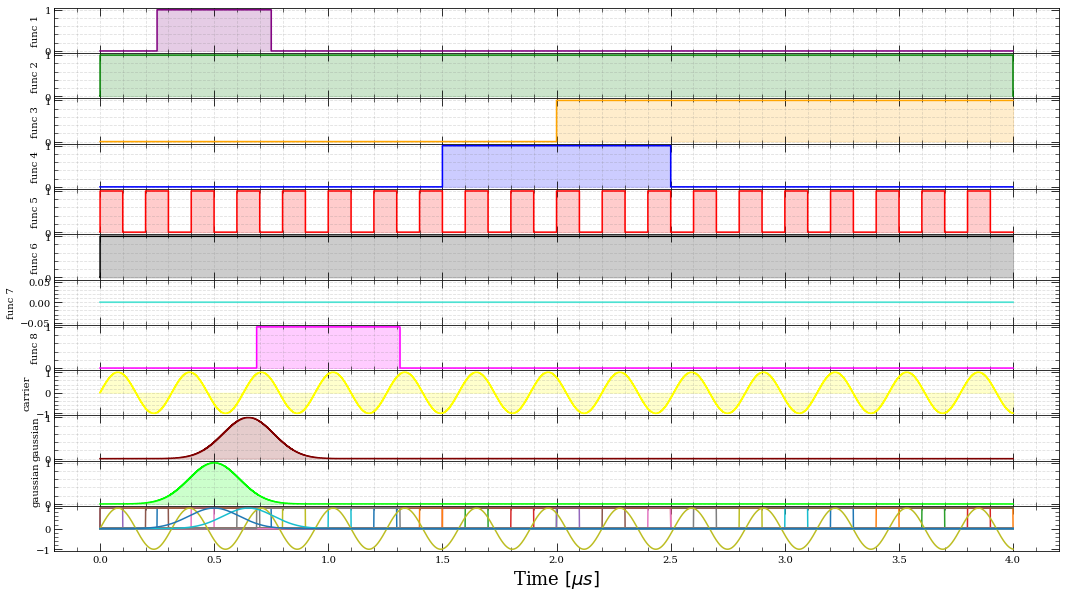

In [2]:
nr_physical_ops = 11;

#PULSE SPECIFICATIONS
args = {'sampling':int(5e3), 'bitdepth':16, 'time_dyn':4}; #dictionary of general parameters introduced by user
params = aqipt.general_params(args); #get params AQiPT object from dictionary
tbase = params.timebase(); #obtain time-base from params object

color_lst = ['purple', 'green', 'orange', 'blue', 'red',
             'black', 'turquoise', 'magenta', 'yellow', 'maroon', 
             'lime', 'sienna', 'limegreen', 'violet', 'dodgerblue']; #list of colors

nr_stroboscopic = 90;
twidth_pulse = 0.1; #us

#FUNCTION FOR PULSES
#function parameters
args_lst=[{'amp': 1, 't_o':0.5, 'width': 0.25, 'tp_window': params.dyn_time, 'name': 'func 1', 'color': color_lst[0], 'type': None},
         {'amp': 1, 't_o':2, 'width': 2,'tp_window': params.dyn_time, 'name': 'func 2', 'color': color_lst[1], 'type': None},
         {'amp': 1, 't_o':4, 'width': 2,'tp_window': params.dyn_time, 'name': 'func 3', 'color': color_lst[2], 'type': None},
         {'amp': 1, 't_o':2, 'width': 0.5,'tp_window': params.dyn_time, 'name': 'func 4', 'color': color_lst[3], 'type': None},
         {'amp': 1, 't_o':0.05, 'width':0.05,'tp_window': params.dyn_time, 'name': 'func 5', 'color': color_lst[4], 'type': 'stroboscopic'},
         {'amp': 1, 't_o':5, 'width': 5,'tp_window': params.dyn_time, 'name': 'func 6', 'color': color_lst[5], 'type': None},
         {'amp': 1, 't_o':5, 'width': 1,'tp_window': params.dyn_time, 'name': 'func 7', 'color': color_lst[6], 'type': None},
         {'amp': 1, 't_o':1, 'width': np.pi/10,'tp_window': params.dyn_time, 'name': 'func 8', 'color': color_lst[7], 'type': None},
         {'Amp':1, 'freq':20/(2*np.pi), 'phase':0,'tp_window': params.dyn_time, 'name': 'carrier', 'color': color_lst[8], 'type': None},
         {'g_Amp':1, 'g_center': 0.65, 'g_std':np.pi/40,'tp_window': params.dyn_time, 'name': 'gaussian', 'color': color_lst[9], 'type': None},
         {'g_Amp':1, 'g_center': 0.5, 'g_std':np.pi/40,'tp_window': params.dyn_time, 'name': 'gaussian', 'color': color_lst[10], 'type': None}];

fig, axs = plt.subplots(nr_physical_ops+1, 1, figsize=(18,10), sharex=True);
fig.subplots_adjust(hspace=0);

funcs_lst=[];
for _ in range(nr_physical_ops):

    #function creation
    tp_window = args_lst[_]['tp_window']; 
    
        
    if args_lst[_]['name'] == 'carrier':
        tp = np.linspace(0, tp_window, params.sampling);
        func, plot = control.function(tp, args_lst[_]).sinusoidal();
        funcs_lst.append(func);

    elif args_lst[_]['name'] == 'gaussian':
        tp = np.linspace(0, tp_window, int((tp_window-0)*params.sampling/params.dyn_time));
        func, plot = control.function(tp, args_lst[_]).gaussian();
        funcs_lst.append(func);

    else:
        tp = np.linspace(0, tp_window, int((tp_window-0)*params.sampling/params.dyn_time)); #time domain function
        func, plot = control.function(tp, args_lst[_]).step(plotON=False);
        funcs_lst.append(func);
    
    if args_lst[_]['type'] == 'stroboscopic':
        
        for _k in range(nr_stroboscopic):
                        
            args_lst[_]['t_o']+=twidth_pulse*2
            tp = np.linspace(0, tp_window, int((tp_window-0)*params.sampling/params.dyn_time));
            func, plot = control.function(tp, args_lst[_]).step(plotON=False);
            funcs_lst[_]=np.add(funcs_lst[_],func);

_=0;
for func in funcs_lst:
    
    #ploting
    axs[_].step(tp, func, color=args_lst[_]['color'], where='mid');
    axs[_].fill_between(tp, func, color=args_lst[_]['color'], step="mid", alpha=0.2);
    axs[_].set_ylabel(args_lst[_]['name']);
    axs[_].minorticks_on();
    axs[_].grid(b=True, which='both', color='gray', linestyle='--', alpha=0.25);
    plt.xlabel(r'Time $[\mu s]$', fontsize=18);
    
    _+=1;

---

# atomicModels (quantum dits)

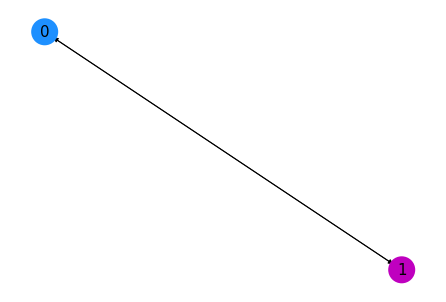

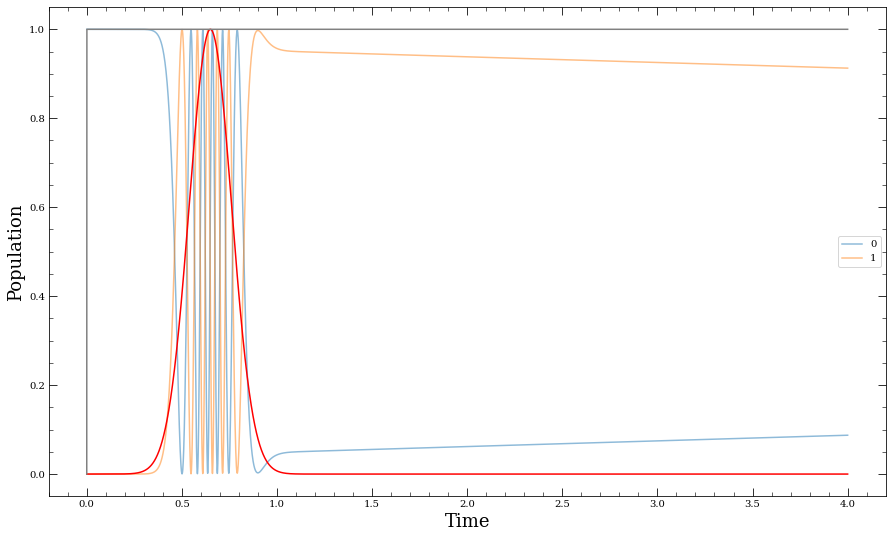

In [3]:
#PULSED QUBIT 1
Nrlevels = 2; #nr of levels in the system
psi0 = 0; #initial state

times = params.timebase(); #time of the dynamics

couplings_q1 = {'Coupling0': [[0,1], 2*np.pi*10, funcs_lst[9]]}; #couplings list within the states [i,j], couplingValue, pulse
detunings_q1 = {'Detuning0': [[1,1], -2*np.pi*0., funcs_lst[5]]}; #detuning list in the state i as [i,i], detuningValue, pulse          
dissipators_q1 = {'Dissipator0': [[0,1], 2*np.pi*0.00219]}; #dissipator list within the states [i,j], dissipatorStrenght
Rydbergstates_q1 = {'RydbergStates': [1], 'l_values':[0]}; #label the Rydberg states

sim_params_q1 = {'couplings': couplings_q1,
                 'detunings': detunings_q1,
                 'dissipators': dissipators_q1,
                 'rydbergstates': Rydbergstates_q1}; #wrapping dynamic params in dictionary

pulsed_qubit1 = emulator.atomicModel(times, Nrlevels, psi0, sim_params_q1, name = 'qubit 1'); #model class of AQiPT model(timeOfdynamics, NumberOfLevels, InitialState, DynamicParams, NameLabel)

pulsed_qubit2_Map = pulsed_qubit1.modelMap(plotON=True); #defining the map of the AtomicQuantumRegister

pulsed_qubit1.buildTHamiltonian(); #building Time-depnedent Hamiltonian
pulsed_qubit1.buildLindbladians(); #building Lindbladians
pulsed_qubit1.buildObservables(); #building Observables
pulsed_qubit1.playSim(mode='control'); #playing simulation
pulsed_qubit1.showResults(); #ploting

plt.plot(times, funcs_lst[9], color='red');
plt.plot(times, funcs_lst[5], color='gray');


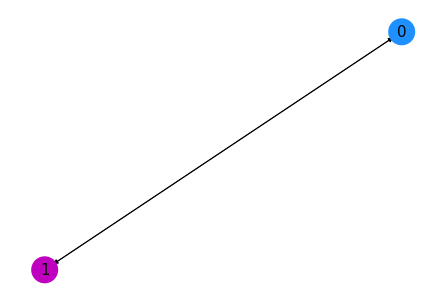

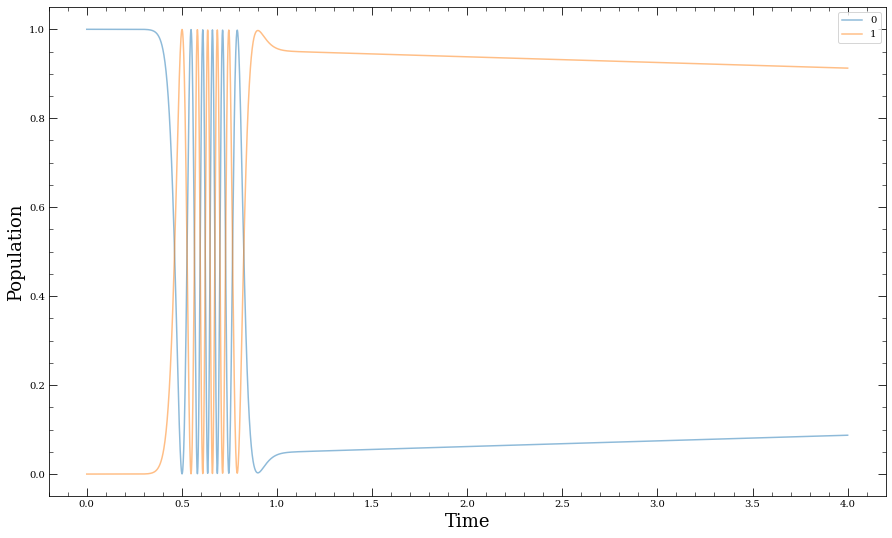

In [4]:
#PULSED QUBIT 2
Nrlevels = 2; #nr of levels in the system
psi0 = 0; #initial state

times = params.timebase(); #time of the dynamics

couplings_q2 = {'Coupling0': [[0,1], 2*np.pi*10, funcs_lst[9]]}; #couplings list within the states [i,j], couplingValue, pulse
detunings_q2 = {'Detuning0': [[1,1], -2*np.pi*0., funcs_lst[5]]}; #detuning list in the state i as [i,i], detuningValue, pulse          
dissipators_q2 = {'Dissipator0': [[0,1], 2*np.pi*0.00219]}; #dissipator list within the states [i,j], dissipatorStrenght
Rydbergstates_q2 = {'RydbergStates': [1], 'l_values':[0]}; #label the Rydberg states

sim_params_q2 = {'couplings': couplings_q2, 
                 'detunings': detunings_q2, 
                 'dissipators': dissipators_q2,
                 'rydbergstates': Rydbergstates_q2}; #wrapping dynamic params in dictionary

pulsed_qubit2 = emulator.atomicModel(times, Nrlevels, psi0, sim_params_q2, name = 'qubit 2'); #model class of AQiPT model(timeOfdynamics, NumberOfLevels, InitialState, DynamicParams, NameLabel)

pulsed_qubit2_Map = pulsed_qubit2.modelMap(plotON=True); #defining the map of the AtomicQuantumRegister

pulsed_qubit2.buildTHamiltonian(); #building Time-depnedent Hamiltonian
pulsed_qubit2.buildLindbladians(); #building Lindbladians
pulsed_qubit2.buildObservables(); #building Observables
pulsed_qubit2.playSim(mode='control'); #playing simulation
pulsed_qubit2.showResults(); #ploting

# plt.fill(times, funcs_lst[7], color='red', alpha=0.2);
# plt.fill(times, funcs_lst[5], color='gray', alpha=0.2);


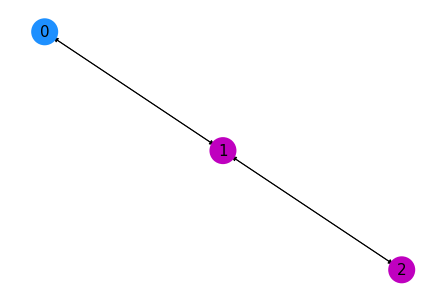

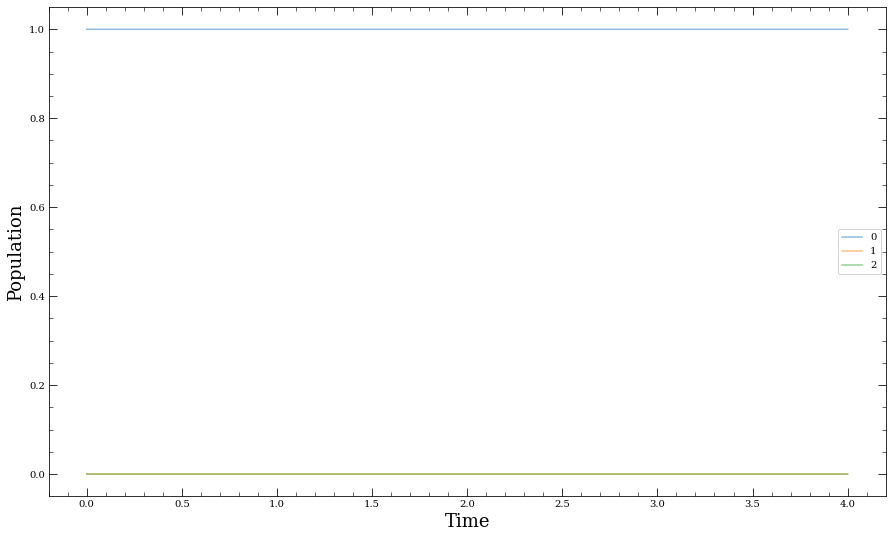

In [5]:
#PULSED QUTRIT 1
Nrlevels = 3; #nr of levels in the system
psi0 = 0; #initial state

times = params.timebase(); #time of the dynamics

couplings_q3 = {'Coupling0': [[0,1], 2*np.pi*10, funcs_lst[6]],
                'Coupling1': [[1,2], 2*np.pi*10, funcs_lst[6]]}; #couplings list within the states [i,j], couplingValue, pulse
detunings_q3 = {'Detuning0': [[1,1], -2*np.pi*0., funcs_lst[5]],
                'Detuning1': [[1,1], -2*np.pi*0., funcs_lst[5]]}; #detuning list in the state i as [i,i], detuningValue, pulse          
dissipators_q3 = {'Dissipator0': [[0,1], 2*np.pi*0.00219],
                  'Dissipator0': [[0,1], 2*np.pi*0.00219]}; #dissipator list within the states [i,j], dissipatorStrenght
Rydbergstates_q3 = {'RydbergStates': [1,2], 'l_values':[0, 1]}; #label the Rydberg states

sim_params_q3 = {'couplings': couplings_q3, 
                 'detunings': detunings_q3, 
                 'dissipators': dissipators_q3,
                 'rydbergstates': Rydbergstates_q3}; #wrapping dynamic params in dictionary

pulsed_qutrit1 = emulator.atomicModel(times, Nrlevels, psi0, sim_params_q3, name = 'qutrit 1'); #model class of AQiPT model(timeOfdynamics, NumberOfLevels, InitialState, DynamicParams, NameLabel)

pulsed_qutrit1_Map = pulsed_qutrit1.modelMap(plotON=True); #defining the map of the AtomicQuantumRegister

pulsed_qutrit1.buildTHamiltonian(); #building Time-depnedent Hamiltonian
pulsed_qutrit1.buildLindbladians(); #building Lindbladians
pulsed_qutrit1.buildObservables(); #building Observables
pulsed_qutrit1.playSim(mode='control'); #playing simulation
pulsed_qutrit1.showResults(); #ploting

# plt.plot(times, funcs_lst[9], color='red');
# plt.plot(times, funcs_lst[10], color='gray');
# plt.plot(times, funcs_lst[5], color='darkblue');



---

# atomicQRegister

## Qubit+Qubit+Qutrit

12
Violet nodes: Rydberg states. Blue nodes: Ground states


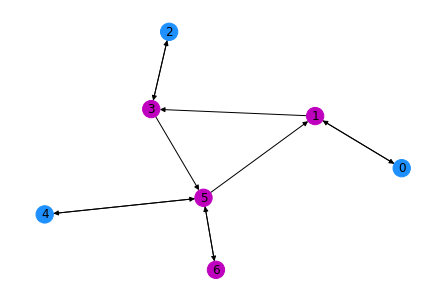

In [6]:
AtomicQC_pulsed = emulator.atomicQRegister(physicalRegisters=[pulsed_qubit1, pulsed_qubit2, pulsed_qutrit1],
                                           initnState='000',
                                           name='qubit 1 + qubit 2 + qutrit 1',
                                           connectivity=['Directed', [(1,3),(3,5),(5,1)]],#['All', []],
                                           layout=[(0,0,0), (0,1,0), (1,0,0)]); #build time-dependent quantum register

AtomicQC_pulsed.buildTNHamiltonian(); #build time-dependent N model Hamiltonian
AtomicQC_pulsed.buildNLindbladians(); #build N model Lindabladians
AtomicQC_pulsed.buildNObservables(); #build N model Observables
AtomicQC_pulsed.buildNinitState(); #build N model initial state

# qt.hinton(AtomicQC_pulsed.nHamiltonian,xlabels=None, ylabels=None, title='Hamiltonian', ax=None);
# qt.hinton(AtomicQC_pulsed.Hamiltonian,xlabels=None, ylabels=None, title='Hamiltonian', ax=None);
# qt.hinton(AtomicQC_pulsed.Hamiltonian,xlabels=None, ylabels=None, title='Hamiltonian', ax=None);

AtomicQC_pulsed.simOpts = qt.Options(nsteps=10000, rtol=1e-6, max_step=10e-6);

# AtomicQC_pulsed.playSim(mode='control');
# AtomicQC_pulsed.showResults(figureSize=(14,8));

# plt.plot(times, funcs_lst[7], color='black');
# plt.legend(['00','01','10','11','Pulse',]);
AtomicQC_pulsed.registerMap();


The initial state is:

In [7]:
AtomicQC_pulsed.initnState

Quantum object: dims = [[12], [1]], shape = (12, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

The list of Rydberg states are stores in the atomicQRegister object:

In [8]:
AtomicQC_pulsed._rydbergstates

[1, 3, 5, 6]

and separated by register:

In [9]:
AtomicQC_pulsed._HSlist

[[1], [3], [5, 6]]

We can also obtain the connectivity node-tuple list for getting which states are interacting:

In [10]:
AtomicQC_pulsed.connectivity

[(1, 3), (3, 5), (5, 1)]

Then a simplified version of the register map (used later for quantum circuits compilation) can be observe, here the notion of atomic levels of each register is not taking into account by rather an architecture map:

no implemented completely yet


{'q0': {'Position': (0, 0, 0),
  'qMap': [[0, 1], [2, 0]],
  'Connectivity': [(1, 3), (5, 1)]},
 'q1': {'Position': (0, 1, 0),
  'qMap': [[0, 1], [1, 2]],
  'Connectivity': [(1, 3), (3, 5)]},
 'q2': {'Position': (1, 0, 0),
  'qMap': [[1, 2], [2, 0]],
  'Connectivity': [(3, 5), (5, 1)]}}

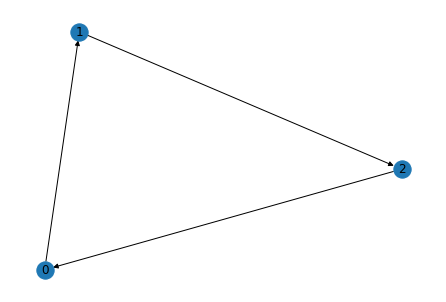

In [11]:
AtomicQC_pulsed.compile()
AtomicQC_pulsed.compileQRegister

we can extract the operatos of the time-dependent Hamiltonians used in the system:

In [12]:
AtomicQC_pulsed.tnHamiltonian[4][0]

Quantum object: dims = [[12], [12]], shape = (12, 12), type = oper, isherm = True
Qobj data =
[[ 0.         62.83185307  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [62.83185307  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         62.83185307  0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         62.83185307  0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.       

We can also extract the interaction operator basis:

[Quantum object: dims = [[12], [12]], shape = (12, 12), type = oper, isherm = True
 Qobj data =
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]],
 Quantum object: dims = [[12], [12]], shape = (12, 12), type = oper, isherm = True
 Qobj data =
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 

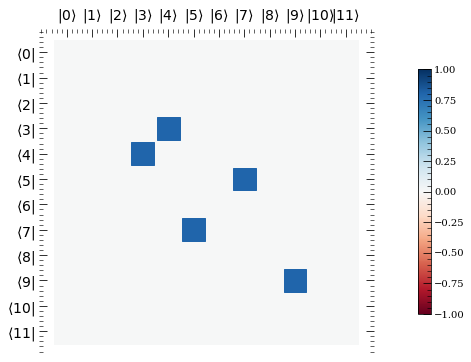

In [13]:
AtomicQC_pulsed._buildInteractingBasis()
qt.hinton(sum(AtomicQC_pulsed._intbasis))

AtomicQC_pulsed._intbasis

Then building the interactions between the registers and plotting the solutions:

(0.0, 1.5)

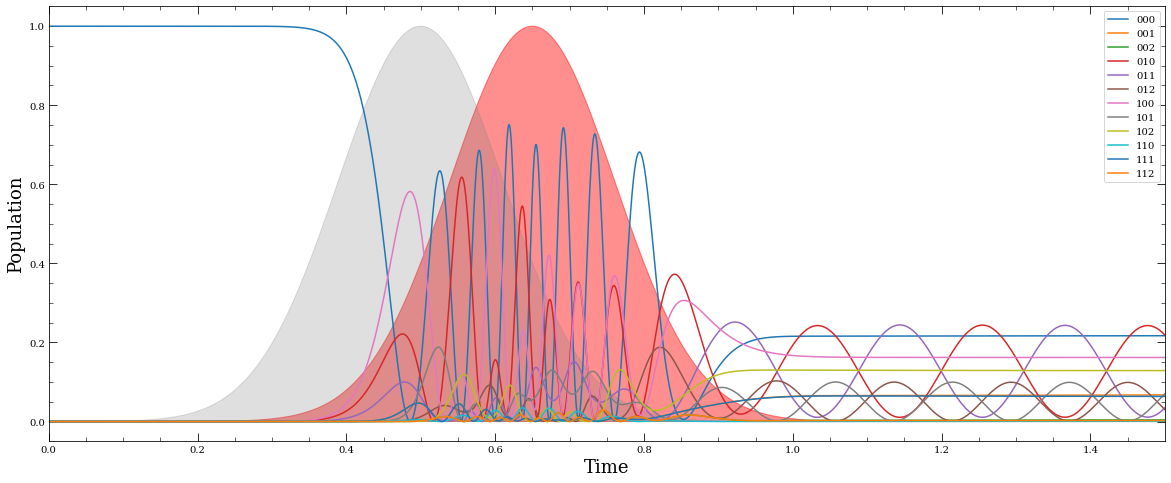

In [14]:
AtomicQC_pulsed.buildInteractions();
AtomicQC_pulsed.simOpts = qt.Options(nsteps=6000, rtol=1e-5, max_step=1e-5)
AtomicQC_pulsed.playSim(mode='control');
AtomicQC_pulsed.showResults(figureSize=(20,8));


plt.fill(times, funcs_lst[9], color='red', alpha=0.25);
plt.fill(times, funcs_lst[9], color='red', alpha=0.25);
plt.fill(times, funcs_lst[10], color='gray', alpha=0.25);
plt.xlim(0,1.5)

Improving the color lines for legend:

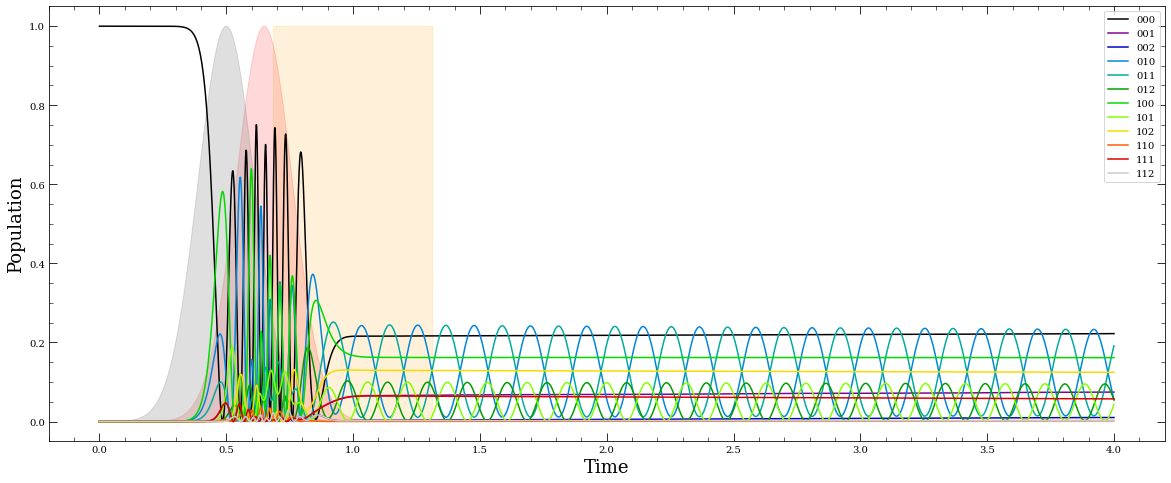

In [15]:
fig1 = plt.figure(figsize=(20,8))
ax1 = fig1.add_subplot(111)

AtomicQC_pulsed.showResults(resultlabel=None, figureSize=(20,8), figure=fig1, axis=ax1);

plt.fill(times, funcs_lst[7], color='orange', alpha=0.15);
plt.fill(times, funcs_lst[9], color='red', alpha=0.15);
plt.fill(times, funcs_lst[10], color='gray', alpha=0.25);

# plt.xlim(1.50,2.5);
# plt.ylim(0,0.1);